# Swaption pricing
## Packages import


In [ ]:
from scipy.stats import norm
from math import exp, sqrt, log
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('bmh')

## Data Loading

In [ ]:
filename = 'caps_data_combined.csv'

caps_data = pd.read_csv(filename)

caps_data['CapStrike'] /= 100
caps_data['CapVols'] /= 100
caps_data = caps_data.dropna(subset=['CapVols'])
caps_data['PV'] = pd.to_numeric(caps_data['PV'])

cap_dfs = {}
CAP_IDS = np.unique(caps_data['cap_id'])
for cap_id in CAP_IDS:
    cap_dfs[cap_id] = caps_data[caps_data['cap_id'] == cap_id].copy()

caps = [cap_dfs[i] for i in CAP_IDS]

# show example dataframe for one cap
caps[1]

,Expiry,Pay Date,Days,Notional,CapStrike,CapVols,Reset Rate,Hedge Ratio,Equiv. Coupon,Payment,Discount,Intrinsic PV,Time PV,PV,cap_id,T_i,T_iM1,tau_i
121,2024-11-29,2025-03-03,90,10000000,0.021,0.3182,3.09406,0.99,0.9949,24871.60,0.983946,24452.48,19.82,24472.30,2,0.513889,0.252778,0.261111
122,2025-02-27,2025-06-03,92,10000000,0.021,0.3281,2.67656,0.87,0.6165,15753.77,0.977475,14402.42,996.50,15398.92,2,0.769444,0.502778,0.266667
123,2025-05-30,2025-09-03,92,10000000,0.021,0.3421,2.37790,0.71,0.4232,10815.01,0.971753,6901.21,3608.31,10509.52,2,1.025000,0.758333,0.266667
124,2025-09-01,2025-12-03,91,10000000,0.021,0.3831,2.25349,0.64,0.4121,10415.92,0.966554,3750.21,6317.34,10067.55,2,1.277778,1.019444,0.258333
125,2025-12-01,2026-03-03,90,10000000,0.021,0.3922,2.17676,0.61,0.4098,10245.02,0.961440,1845.10,8004.86,9849.96,2,1.527778,1.272222,0.255556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2053-05-30,2053-09-03,92,10000000,0.021,0.4207,1.78686,0.44,1.2853,32845.69,0.506999,0.00,16652.74,16652.74,2,29.433333,29.166667,0.266667
236,2053-09-01,2053-12-03,91,10000000,0.021,0.4218,1.78681,0.44,1.2916,32649.70,0.504660,0.00,16477.01,16477.01,2,29.686111,29.427778,0.258333
237,2053-12-01,2054-03-03,90,10000000,0.021,0.4228,1.78677,0.43,1.2978,32444.64,0.502358,0.00,16298.81,16298.81,2,29.936111,29.680556,0.255556
238,2054-02-27,2054-06-03,92,10000000,0.021,0.4238,1.78686,0.43,1.3038,33318.28,0.500015,0.00,16659.63,16659.63,2,30.191667,29.925000,0.266667


## Initial term structure

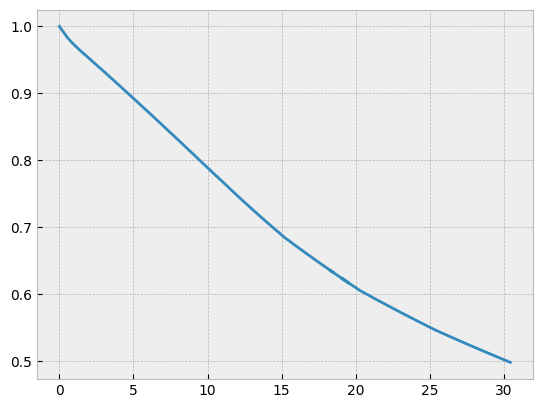

In [ ]:
ts = np.append(0, cap_dfs[1]['T_i'].values)
ds = np.append(1, cap_dfs[1]['Discount'].values)
r0 = 0.0366 # 3.66% -> ESTR rate on the 30th August 2024

delta_t = 1e-03

PM = lambda t: np.interp(t, ts, ds)
f_instantaneous = lambda t: r0 if t == 0 else -(np.log(PM(t+delta_t)) - np.log(PM(t-delta_t)))/(2*delta_t)
plt.plot(ts, ds)

## Black pricing formula for a Cap

In [ ]:
def caplet_black(caplet, P_t, P_s):
    tau = caplet['T_i'] - caplet['T_iM1']

    F = (P_t / P_s - 1) / tau
    if F == 0: return 0

    K = caplet['CapStrike']
    sigma = caplet['CapVols']

    v = sigma * np.sqrt(caplet['T_iM1'])
    tmp = max(F/K, sys.float_info.min) # to avoid rare cases of negative forward rate
    d1 = (np.log(tmp) + 0.5*v**2) / v
    d2 = (np.log(tmp) - 0.5*v**2) / v

    black = F * norm.cdf(d1) - K * norm.cdf(d2)
    if np.isnan(black):
        print(f'{K}, {F}, {P_t}, {P_s}')
    return caplet['Notional'] * P_s * tau * black

def cap_black(cap):
    price = 0
    for i in range(1, len(cap)):
        P_t = cap['Discount'].iloc[i-1]
        P_s = cap['Discount'].iloc[i]
        caplet = cap.iloc[i]

        caplet_price = caplet_black(caplet, P_t, P_s)
        price += caplet_price

    return price


def obj_func(x, caps, r0):
    # implement the objective function for the optimization (diff of HW cap price compared to the market price of the cap)
    k = x[0]
    sigma = x[1]
    r_t = r0

    diffs = np.zeros(len(caps))
    N = caps[0].iloc[0]['Notional']

    for i, cap in enumerate(caps):
        cap_price_HW = cap_HW(cap,k,sigma,r_t) / N
        cap_price_black = cap_black(cap) / N
        diffs[i] = cap_price_HW - cap_price_black

    # return (cap_price_HW - cap_price_black)**2
    return (diffs**2).sum()

# Check between the Black prices and Bloomberg prices
print(cap_black(caps[1]))
print(caps[1]['PV'].sum())

2492880.3135172087
2493318.0900000003


## Hull-White price of a Cap

In [ ]:
def B(k, t, T):
    return (1 - np.exp(-k * (T - t))) / k


def P_HW(t, T, k, sigma, r_t, P_t=None, P_T=None):
    if P_t is None: P_t = PM(t)
    if P_T is None: P_T = PM(T)

    B_tT = B(k,t,T)
    A_tT = P_T / P_t * np.exp(B_tT*f_instantaneous(t) - sigma**2/(4*k) * (1-np.exp(-2*k*t)) * B_tT**2)
    return A_tT*np.exp(-B_tT*r_t)


def ZCB_put(t,T,S,X,k,sigma,r_t, P_t=None, P_T=None, P_S=None):
    sigma_p = sigma * np.sqrt((1-np.exp(-2*k*(T-t)))/(2*k)) * B(k,T,S)

    P_t_S =  P_HW(t, S, k, sigma, r_t, P_t=P_t, P_T=P_S)
    P_t_T = P_HW(t, T, k, sigma, r_t, P_t=P_t, P_T=P_T)

    h = 1/sigma_p * np.log(P_t_S / (X*P_t_T)) + 0.5*sigma_p
    temp = max(P_t_S / (P_t_T * X), sys.float_info.min)
    h = (1 / sigma_p) * log(temp)
    h = h + sigma_p / 2

    result = X*P_HW(t, T, k, sigma, r_t, P_t=P_t, P_T=P_T) * norm.cdf(-h+sigma_p) - P_HW(t, S, k, sigma, r_t, P_t=P_t, P_T=P_S) * norm.cdf(-h)
    return result

def caplet_HW(t, t_iM1, t_i, N, X, k, sigma, r_t, P_t=None, P_T=None, P_S=None):
    tau = t_i - t_iM1
    N_prime = N*(1+X*tau)
    X_prime = 1/(1+X*tau)
    put = ZCB_put(t, t_iM1, t_i, X_prime, k, sigma, r_t, P_t=P_t, P_T=P_T, P_S=P_S)
    return N_prime * put


def cap_HW(cap,k,sigma,r_t):
    price = 0
    for i in range(1,len(cap)):
        caplet_price = caplet_HW(t=0,\
                           t_i=cap.iloc[i]['T_i'],\
                           t_iM1=cap.iloc[i]['T_iM1'],
                           N=cap.iloc[i]['Notional'],\
                           X=cap.iloc[i]['CapStrike'],\
                           k=k,\
                           sigma=sigma,\
                           r_t=r_t,\
                           P_t=1,\
                           P_T=cap.iloc[i-1]['Discount'],\
                           P_S=cap.iloc[i]['Discount'])
        price += caplet_price
    return price

## Model Calibration
Below we implement the model calibration process with multiple strating points (initial guesses), as this optimization process is often not a convex problem and it can get stuck in a local optimum. Formally, the optimization process can be written as follows:
$$
\mathbf{\Theta} = \arg\min_{(k,\sigma)}\sum_{i=0}^L \left(\mathbf{Cap}^{HW}_i(0,T_b,N,X) - \mathbf{Cap}^{Black}_i(0,T_b,N,X)\right)^2
$$

In [ ]:
init_guesses = [[0.2, 0.2], [0.1, 0.2], [0.05, 0.02], [0.1, 0.03], [0.4, 0.1]]
calibration_results = []

for initialGuess in tqdm(init_guesses):
    bnds = ((0.001,None),(0.001,None))

    result = minimize(obj_func, initialGuess, args=(caps, r0), bounds = bnds, method = 'Nelder-Mead', tol=1e-04)

    optPar = result.x
    kstar = optPar[0]
    sigma_star = optPar[1]

    calibration_results.append([kstar, sigma_star, result.fun])

100%|██████████| 5/5 [07:43<00:00, 92.62s/it] 


In [ ]:
calibration_df = pd.DataFrame(calibration_results, columns=['k_star', 'sigma_star', 'func_value'])

# choose the parameters with minimal objective function value
min_error = calibration_df['func_value'].min()
opt_par = calibration_df[calibration_df['func_value'] == min_error].iloc[0]

kstar = opt_par['k_star']
sigma_star = opt_par['sigma_star']

print(f'k_star = {kstar}\nsigma_star = {sigma_star}')
calibration_df

k_star = 0.3712432413955632
sigma_star = 0.023955133389276045


,k_star,sigma_star,func_value
0,0.371207,0.023954,0.000006
1,0.001000,0.001000,0.096485
2,0.371192,0.023953,0.000006
3,0.371178,0.023953,0.000006
4,0.371243,0.023955,0.000006


## Validation of initial term structure fit

Text(0, 0.5, 'Bond price')

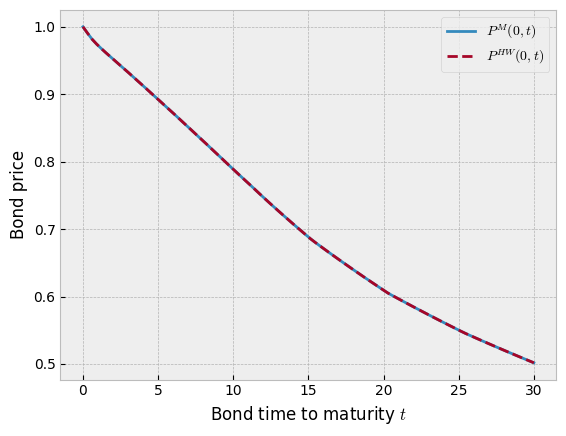

In [ ]:
# Check if the model indeed fits the initial term structure as it should
times = np.linspace(0,30,100)

df = pd.DataFrame()
prices_hw = []
prices_m = []
for T in times:
    prices_hw.append(P_HW(0, T, kstar, sigma_star, r0, P_t=1, P_T=PM(T)))
    prices_m.append(PM(T))

df['HW'] = prices_hw
df['Mkt'] = prices_m
df.index = times

plt.plot(times, df['Mkt'], ls='-', label='$P^M(0,t)$')
plt.plot(times, df['HW'], ls='--', label='$P^{HW}(0,t)$')
plt.legend()
plt.xlabel('Bond time to maturity $t$')
plt.ylabel('Bond price')
# plt.savefig('plots/term_structure_fit.pgf')

## Simulation of interest rate paths across time

Here we we will simulate a few paths of the short rate with calibrated parameters.

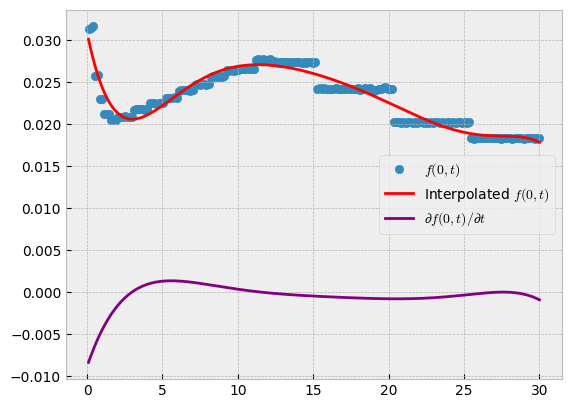

In [ ]:
times = np.linspace(0.1,30,200)
fs = np.array([f_instantaneous(t) for t in times])

z = np.polyfit(times, fs, 7)
f_int = np.poly1d(z)

partial_f = lambda t: (f_int(t+delta_t) - f_int(t)) / delta_t if t==0 else (f_int(t+delta_t) - f_int(t-delta_t)) / (2*delta_t)

partial_fs = np.array([partial_f(t) for t in times])

plt.scatter(times,fs, label='$f(0,t)$')
plt.plot(times, f_int(times), c='r', label='Interpolated $f(0,t)$')
plt.plot(times,partial_fs, c='purple', label='$\\partial f(0,t)/\\partial t$')
plt.legend()

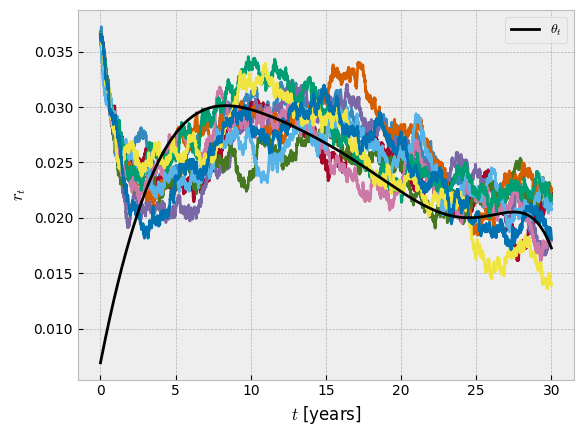

In [ ]:
def theta(t, k, sigma):
    return f_int(t) + 1/k * partial_f(t) + sigma**2 / (2*k**2) * (1-np.exp(-2*k*t))

T = 30
N = 5000
dt = T/N

M = 10 # number of paths
np.random.seed(280400)

paths = np.zeros((M,N+1))
paths[:,0] = r0
thetas = np.zeros_like(paths)

for i in range(N+1):
    thetas[:,i] = theta(i*dt,kstar,sigma_star)
thetas

for i in range(1,N+1):
    dw = np.random.normal(0,dt, size=M)
    dr = kstar * (theta(i*dt,kstar,sigma_star) - paths[:,i-1]) * dt + sigma_star * dw
    paths[:,i] = paths[:,i-1] + dr

plt.plot(np.linspace(0,T,N+1), paths.T)
plt.plot(np.linspace(0,T,N+1), thetas[0,:], c='black',lw=2,label='$\\theta_t$')
plt.legend()
plt.xlabel('$t$ [years]')
plt.ylabel('$r_t$')
# plt.savefig('plots/paths.pgf')
plt.show()

Here is a sample of a few simulations of the short rate paths across 30 years period. What is very interesting to observe and gives us confidence that the model was properly calibrated is the fact that all paths have a sharp decrease in the first 2 years of the simulation, reflecting the amount of interest rate cuts priced in by the market at the time of extracting the data (30th August 2024).

# Swaption pricing

## Implementation of IRS pricing formula

$$IRS(t) = \sum_{i=1}^b P(t,T_i^x)\tau(T_{i-1}^x,T_i^x)F(t,T_{i-1}^x,T_i^x) - \sum_{j=1}^c P(t,T_j)\tau(T_{j-1},T_j)S_b^x(t)$$

where the price of a bond $P(t,T)$ is given by
$$
P(t, T)=A(t, T) e^{-B(t, T) r(t)},
$$
and where elements $A(\cdot,\cdot)$ and $B(\cdot,\cdot)$ are:
$$
A(t, T)=\frac{P^M(0, T)}{P^M(0, t)} \exp \left\{B(t, T) f^M(0, t)-\frac{\sigma^2}{4 a}\left(1-e^{-2 a t}\right) B(t, T)^2\right\} .
$$
$$
B(t, T)=\frac{1}{a}\left[1-e^{-a(T-t)}\right]
$$


In [ ]:
def visualize_lattice(lattice, T):
    dt = T / (lattice.shape[1] - 1)
    for i in range(lattice.shape[1]):
        pnts = lattice[0:i+1,i]
        ts = np.array([dt*i] * (i+1))
        plt.scatter(ts,pnts,c='g')
    plt.show()


def swap_rate(t, rt, T0, fixed_Ts, k, sigma):
    denominator = 0
    for j in range(len(fixed_Ts)):
        Tj = fixed_Ts[j]
        tau = Tj - T0 if j == 0 else Tj - fixed_Ts[j-1]
        denominator += P_HW(t=t, T=Tj, k=k, sigma=sigma, r_t=rt, P_t=None, P_T=None) * tau

    P_first = P_HW(t=t, T=T0, k=k, sigma=sigma, r_t=rt, P_t=None, P_T=None)
    P_last = P_HW(t=t, T=fixed_Ts[-1], k=k, sigma=sigma, r_t=rt, P_t=None, P_T=None)

    return (P_first - P_last) / denominator

def irs(t, fixed_Ts, rt, sr, k, sigma):
    first = P_HW(t=t, T=fixed_Ts[-1], k=k, sigma=sigma, r_t=rt, P_t=None, P_T=None)
    summ = 0
    for j in range(len(fixed_Ts)):
        Tj = fixed_Ts[j]
        tau = Tj - t if j == 0 else Tj - fixed_Ts[j-1]
        summ += P_HW(t=t, T=Tj, k=k, sigma=sigma, r_t=rt, P_t=None, P_T=None) * tau * sr

    return 1 - first - summ

# testing the swap rate functions for a forward start swap -> We expect the value of zero
sr = swap_rate(t=1, rt=r0+0.01, T0=1, fixed_Ts=[1.25, 1.5, 1.75, 2], k=kstar, sigma=sigma_star)
irs(t=1, fixed_Ts=[1.25, 1.5, 1.75, 2], rt=r0+0.01, sr=sr, k=kstar, sigma=sigma_star)

0.0

## Building the lattice

We will be building the lattice according to the following picture. The lattice will depict the discretiztion of the process $r_t$ in time.

<a target="_blank" href="https://www.imghost.net/VpJugiZKx40Zmv1"><img  src="https://www.imghost.net/ib/wyY9TLRoGQILt9O_1725727421.png" alt="binomial_tree.png" width="600"/></a>

In our implementation, we will use an `np.array` to store the tree in memory. More specifically, the array will look as follows:

$$
\left[
\begin{array}{ccccc}
r_{0,0} & r_{1,0} & r_{2,0} & \cdots & r_{n-1,0} & r_{n,0} \\
        & r_{1,1} & r_{2,1} & \cdots & r_{n-1,1} & r_{n,1} \\
        &         & r_{2,2} & \cdots & r_{n-1,2} & r_{n,1} \\
        &         &         & \ddots & \vdots & \vdots \\
        &         &         &        & r_{n-1,n-1} & r_{n,n-1}\\
        &         &         &        &         & r_{n,n}\\
\end{array}
\right]
$$

We will use an array of the same size to store risk neutral probabilities of transitions:
$$
\left[
\begin{array}{ccccc}
q_{0,0} & q_{1,0} & q_{2,0} & \cdots & q_{n-1,0} & q_{n,0} \\
        & q_{1,1} & q_{2,1} & \cdots & q_{n-1,1} & q_{n,1} \\
        &         & q_{2,2} & \cdots & q_{n-1,2} & q_{n,1} \\
        &         &         & \ddots & \vdots & \vdots \\
        &         &         &        & q_{n-1,n-1} & q_{n,n-1}\\
        &         &         &        &         & q_{n,n}\\
\end{array}
\right]
$$

But we will not need to use the last column of the matrix above as ($q_{n,i},\forall i$) are the probabilities of transitions to states in the step $n+1$, which is not in our interest, as we will set the time $t_n$ to be the maturity of our swaption.

After populating the whole tree up to time $T=t_n$ which is the maturity of the swaption, we will calculate the price of the swaption in all nodes in the last step, as the price at maturity is equal to the payoff:

$$Swaption(T) = \max( 0,IRS(T) ) $$

We will then work our way back through the tree until we populate the whole tree. The price of the swaption will then be in the root node of the tree.



In [ ]:
# Defining maturity of the swaption and the precision of the tree (i.e. granularity)
T = 2
N_steps = 200
dt = T / N_steps

# Initializing the tree
lattice = np.zeros((N_steps+1, N_steps+1))
lattice[0,0] = r0
qs = np.zeros_like(lattice)

# Populating the tree
for i in range(N_steps):
    for j in range(i+1):
        dr = sigma_star * np.sqrt(dt)
        rt = lattice[j,i]
        lattice[j,i+1] = rt + dr
        lattice[j+1,i+1] = rt - dr

        a = kstar*(theta(i*dt,kstar,sigma_star) - rt) # drift
        qs[j,i] = np.maximum(0, np.minimum(1, 0.5 + (a*dt)/(2*dr))) # calculate q probability

if N_steps <= 100:
    visualize_lattice(lattice,T)

pd.DataFrame(lattice)
# pd.DataFrame(qs)

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,200
0,0.0366,0.038996,0.041391,0.043787,0.046182,0.048578,0.050973,0.053369,0.055764,0.058160,...,0.494143,0.496539,0.498934,0.501330,0.503725,0.506121,0.508516,0.510912,0.513307,0.515703
1,0.0000,0.034204,0.036600,0.038996,0.041391,0.043787,0.046182,0.048578,0.050973,0.053369,...,0.489352,0.491748,0.494143,0.496539,0.498934,0.501330,0.503725,0.506121,0.508516,0.510912
2,0.0000,0.000000,0.031809,0.034204,0.036600,0.038996,0.041391,0.043787,0.046182,0.048578,...,0.484561,0.486957,0.489352,0.491748,0.494143,0.496539,0.498934,0.501330,0.503725,0.506121
3,0.0000,0.000000,0.000000,0.029413,0.031809,0.034204,0.036600,0.038996,0.041391,0.043787,...,0.479770,0.482165,0.484561,0.486957,0.489352,0.491748,0.494143,0.496539,0.498934,0.501330
4,0.0000,0.000000,0.000000,0.000000,0.027018,0.029413,0.031809,0.034204,0.036600,0.038996,...,0.474979,0.477374,0.479770,0.482165,0.484561,0.486957,0.489352,0.491748,0.494143,0.496539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.432921,-0.430525,-0.428130,-0.425734,-0.423339
197,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.435316,-0.432921,-0.430525,-0.428130
198,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.437712,-0.435316,-0.432921
199,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.440107,-0.437712


## Pricing swaptions

Here we will price a 2Y swaption on an 5Y IRS with quarterly payments and EURIBOR 3M as a reference rate. We will price it across a set of fixed rates $K$ and compare the results with the results obtained from Refinitiv for the swaption of the same type.

In [ ]:
swap_start = T # This is also the maturity of the swaption
swap_maturity = 5 # years
frequency = 4
fixed_Ts = np.linspace(swap_start, swap_start + swap_maturity, swap_maturity*frequency + 1)[1:] # remove the settlement date of the swap

# Defining the notional value
N = 10_000_000

def swaption_price(lattice, qs, swap_start, fixed_Ts, sr, kstar, sigma_star):
    swaption = np.zeros_like(lattice)
    r_T = lattice[:,-1]

    irs_values = [irs(swap_start, fixed_Ts, r, sr, kstar, sigma_star) for r in r_T]
    swaption[:,-1] = np.maximum(0, irs_values)

    for i in range(N_steps-1, -1, -1):
        for j in range(i+1):
            r = lattice[j,i]
            q = qs[j,i]
            swaption[j,i] = np.exp(-r*dt) * (q*swaption[j,i+1] + (1-q)*swaption[j+1,i+1])

    price = swaption[0,0]
    return price

hw_pcs = []
fixed_rates = np.linspace(0.01, 0.06, 51)
for fixed_rate in tqdm(fixed_rates):
    price = swaption_price(lattice,qs,swap_start,fixed_Ts, fixed_rate, kstar, sigma_star)
    hw_pcs.append(price)

100%|██████████| 51/51 [00:08<00:00,  5.85it/s]


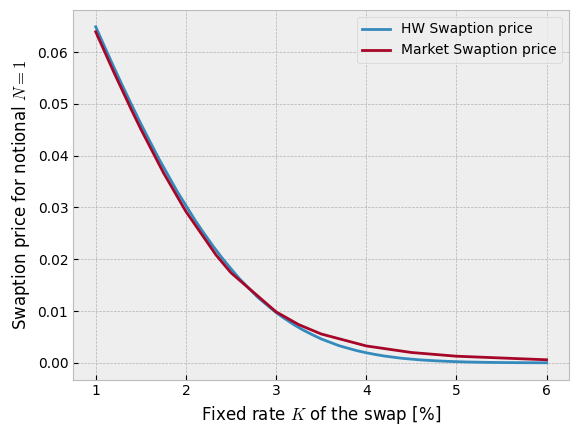

In [ ]:
# Prices taken from the Refinitiv calculator for the swaption of the same type
pairs = [(0.01, 639053.36), \
         (0.023354, 207915.12), \
         (0.03, 98466.79), \
         (0.02, 292240.26), \
         (0.012, 561358.54), \
         (0.014, 486988.45), \
         (0.015, 451300.71), \
         (0.0175, 367330.47), \
         (0.025, 173890.63), \
         (0.0325, 73901.32), \
         (0.035, 55763.54), \
         (0.04, 32660.86), \
         (0.045,20023.06), \
         (0.05, 12847.79), \
         (0.06, 5952.16)]

refinitiv_prices = pd.DataFrame(pairs, columns=['Strike', 'Price']).sort_values('Strike')

# Plot results
plt.plot(fixed_rates*100, hw_pcs, label='HW Swaption price')
plt.plot(refinitiv_prices['Strike']*100, refinitiv_prices['Price']/N, label='Market Swaption price')
plt.xlabel('Fixed rate $K$ of the swap [%]')
plt.ylabel('Swaption price for notional $N=1$')
plt.legend()
# plt.savefig('./plots/swaption_price.pgf')
plt.show()

In [ ]:
# Create a dataframe of relative differences between the model prices and prices obtained from Refinitiv
pcs = []
for sr in refinitiv_prices['Strike']:
    price = swaption_price(lattice,qs,swap_start,fixed_Ts, sr, kstar,sigma_star)
    pcs.append(price)

pcs = np.array(pcs)
refinitiv_prices['HW_Price'] = pcs * N
refinitiv_prices['relative_diff'] = (refinitiv_prices['HW_Price'] - refinitiv_prices['Price']) / refinitiv_prices['Price']

refinitiv_prices

,Strike,Price,HW_Price,relative_diff
0,0.010000,639053.36,648709.238012,0.015110
4,0.012000,561358.54,571208.859311,0.017547
5,0.014000,486988.45,497339.732604,0.021256
6,0.015000,451300.71,461671.645357,0.022980
7,0.017500,367330.47,378569.137354,0.030596
3,0.020000,292240.26,303713.677837,0.039260
1,0.023354,207915.12,216957.295582,0.043490
8,0.025000,173890.63,181609.431738,0.044389
2,0.030000,98466.79,97132.014249,-0.013556
9,0.032500,73901.32,67777.343873,-0.082867
